In [1]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid
from RoutePlanner.IO import LoadIcePoints, LoadCurrentPoints
from RoutePlanner.Optimisation import TravelTime

In [2]:
OptInfo = {}
OptInfo['Bounds Longitude']     = [230,360]
OptInfo['Bounds Latitude']      = [-80,-40]
OptInfo['Grid Spacing (dx,dy)'] = [5,2.5]
OptInfo['Start Time']           = '2017-05-01'
OptInfo['End Time']             = '2017-06-01'
OptInfo['WayPoints']            = pd.read_csv('../../resources/WayPoints_TestExample.csv') 
OptInfo['MaxIceExtent']         = 0.8
OptInfo['Zero Currents']        = True
OptInfo['VariableSpeed']        = False
OptInfo['Time Unit']            = 'days'
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3
OptInfo['VehicleInfo']['Unit']  = 'km/hr'
OptInfo['Start Waypoints']      = None

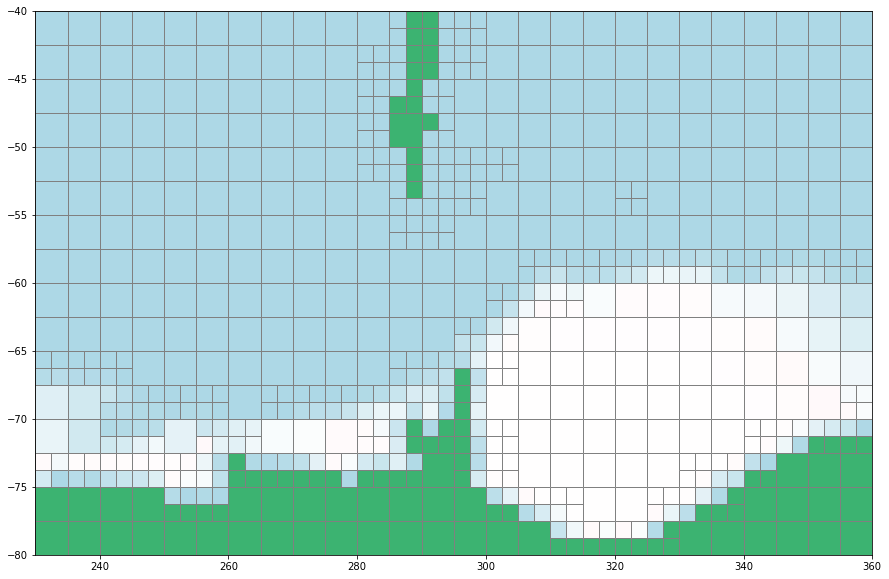

In [3]:
icePoints     = LoadIcePoints('../../Data/bsose_i122_2013to2017_1day_SeaIceArea.nc',OptInfo['Start Time'],OptInfo['End Time'])
currentPoints = LoadCurrentPoints('../../Data/SOSE_surface_velocity_6yearMean_2005-2010.nc')

cellGrid = CellGrid(OptInfo)
cellGrid.addIcePoints(icePoints)
cellGrid.addCurrentPoints(currentPoints)
cellGrid.recursiveSplit(1)
cellGrid.plot()

In [4]:
TT = TravelTime(cellGrid)
TT.Dijkstra(verbrose=True)

=== Processing Waypoint = ArgentineSea ===
=== Processing Waypoint = MargueriteBay ===


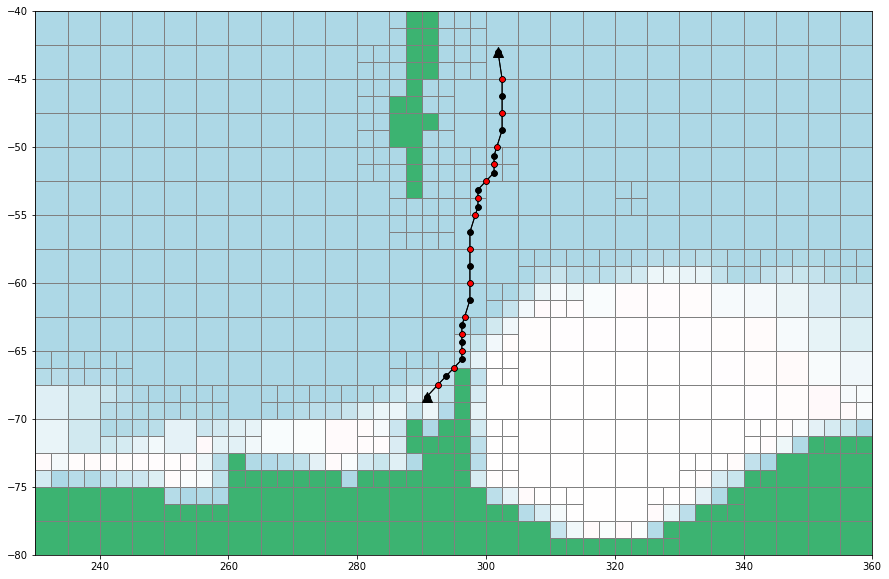

In [5]:
ax = TT.PlotPaths(routepoints=True)
Cps = TT.Paths[0]['Path']['CrossingPoints']
ax.scatter(Cps[:,0],Cps[:,1],15,'r',zorder=200)

In [6]:
TT.PathSmoothing(maxiter=150)

 PATH: ArgentineSea -> MargueriteBay 
Sp=(301.8661111111111,-43.0);Cp=(302.5,-45.0);Np=(302.5,-47.5)
Box1=(-44.0,302.18305555555554);Box2=(-46.25,302.5)
Sp=(302.14784091807013,-45.0);Cp=(302.5,-47.5);Np=(301.6666666666667,-50.0)
Box1=(-46.25,302.3239204590351);Box2=(-48.75,302.08333333333337)
Sp=(301.9070776536079,-47.5);Cp=(301.6666666666667,-50.0);Np=(301.25,-51.25)
Box1=(-48.75,301.7868721601373);Box2=(-50.625,301.45833333333337)
Sp=(301.46890121784287,-50.0);Cp=(301.25,-51.25);Np=(300.0,-52.5)
Box1=(-50.625,301.3594506089214);Box2=(-51.875,300.625)
Sp=(300.7344267771506,-51.25);Cp=(300.0,-52.5);Np=(298.75,-53.75)
Box1=(-51.875,300.3672133885753);Box2=(-53.125,299.375)
Sp=(300.0,-51.875);Cp=(298.75,-52.5);Np=(298.75,-53.75)
Box1=(-52.1875,299.375);Box2=(-53.125,298.75)
Sp=(299.58331641174965,-52.5);Cp=(298.75,-53.75);Np=(298.3333333333333,-55.0)
Box1=(-53.125,299.1666582058748);Box2=(-54.375,298.54166666666663)
Sp=(298.958293705419,-53.75);Cp=(298.3333333333333,-55.0);Np=(297.5,-57.

Sp=(298.1138196729092,-57.5);Cp=(297.3578366642091,-60.0);Np=(296.4570048304376,-62.5)
Box1=(-58.75,297.7358281685591);Box2=(-61.25,296.9074207473234)
Sp=(297.28529872302863,-60.0);Cp=(296.4570048304376,-62.5);Np=(295.8591160870255,-63.75)
Box1=(-61.25,296.8711517767331);Box2=(-63.125,296.15806045873154)
Sp=(296.33443132474787,-62.5);Cp=(295.8591160870255,-63.75);Np=(295.12519044860596,-65.0)
Box1=(-63.125,296.0967737058867);Box2=(-64.375,295.49215326781575)
Sp=(295.7297656969995,-63.75);Cp=(295.12519044860596,-65.0);Np=(295.0,-65.11140063635443)
Box1=(-64.375,295.4274780728027);Box2=(-65.05570031817722,295.062595224303)
Sp=(295.05969278288217,-65.0);Cp=(295.0,-65.11140063635443);Np=(293.55880466819906,-66.25)
Box1=(-65.05570031817722,295.0298463914411);Box2=(-65.68070031817722,294.27940233409953)
Sp=(295.0,-65.05499021762475);Cp=(293.55880466819906,-66.25);Np=(292.5,-67.10240966700437)
Box1=(-65.65249510881237,294.27940233409953);Box2=(-66.67620483350218,293.02940233409953)
Sp=(293.54

Sp=(300.0330549639309,-51.25);Cp=(300.0,-51.39367595504881);Np=(299.65821024417176,-52.5)
Box1=(-51.32183797752441,300.01652748196545);Box2=(-51.94683797752441,299.8291051220859)
Sp=(300.0,-51.367534927391276);Cp=(299.65821024417176,-52.5);Np=(299.2604143083401,-53.75)
Box1=(-51.93376746369564,299.8291051220859);Box2=(-53.125,299.4593122762559)
Sp=(299.64840513311907,-52.5);Cp=(299.2604143083401,-53.75);Np=(298.83952015867,-55.0)
Box1=(-53.125,299.4544097207296);Box2=(-54.375,299.0499672335051)
Sp=(299.24391386956535,-53.75);Cp=(298.83952015867,-55.0);Np=(297.95374850305535,-57.5)
Box1=(-54.375,299.0417170141177);Box2=(-56.25,298.39663433086264)
Sp=(298.81378044355546,-55.0);Cp=(297.95374850305535,-57.5);Np=(297.01567563628043,-60.0)
Box1=(-56.25,298.3837644733054);Box2=(-58.75,297.4847120696679)
Sp=(297.91463313393234,-57.5);Cp=(297.01567563628043,-60.0);Np=(296.0348764179886,-62.5)
Box1=(-58.75,297.4651543851064);Box2=(-61.25,296.5252760271345)
Sp=(296.9746544443523,-60.0);Cp=(296.03

Sp=(301.4196983018364,-45.0);Cp=(300.86188583771747,-47.5);Np=(300.2986255947832,-50.0)
Box1=(-46.25,301.1407920697769);Box2=(-48.75,300.58025571625035)
Sp=(300.85907111925053,-47.5);Cp=(300.2986255947832,-50.0);Np=(300.0132688269558,-51.25)
Box1=(-48.75,300.57884835701685);Box2=(-50.625,300.1559472108695)
Sp=(300.29510950892194,-50.0);Cp=(300.0132688269558,-51.25);Np=(300.0,-51.29420702200931)
Box1=(-50.625,300.15418916793885);Box2=(-51.27210351100466,300.0066344134779)
Sp=(300.01004877041265,-51.25);Cp=(300.0,-51.29420702200931);Np=(299.60155484805466,-52.5)
Box1=(-51.27210351100466,300.0050243852063);Box2=(-51.89710351100466,299.80077742402733)
Sp=(300.0,-51.28283226525425);Cp=(299.60155484805466,-52.5);Np=(299.17250357199674,-53.75)
Box1=(-51.89141613262713,299.80077742402733);Box2=(-53.125,299.38702921002573)
Sp=(299.591714771463,-52.5);Cp=(299.17250357199674,-53.75);Np=(298.7111967425798,-55.0)
Box1=(-53.125,299.3821091717299);Box2=(-54.375,298.9418501572883)
Sp=(299.151411115614

Sp=(293.79710049818806,-65.0);Cp=(292.86535912441235,-66.25);Np=(292.5,-66.6614313929087)
Box1=(-65.625,293.3312298113002);Box2=(-66.45571569645435,292.6826795622062)
Sp=(292.82118899141307,-66.25);Cp=(292.5,-66.6614313929087);Np=(291.6537067946456,-67.5)
Box1=(-66.45571569645435,292.6605944957065);Box2=(-67.08071569645435,292.0768533973228)
Sp=(292.5,-66.62485172914721);Cp=(291.6537067946456,-67.5);Np=(290.75638888888886,-68.38916666666667)
Box1=(-67.06242586457361,292.0768533973228);Box2=(-67.94458333333333,291.2050478417672)
Sp=(301.8661111111111,-43.0);Cp=(301.4157689164092,-45.0);Np=(300.85172298676065,-47.5)
Box1=(-44.0,301.64094001376014);Box2=(-46.25,301.13374595158496)
Sp=(301.41518239077806,-45.0);Cp=(300.85172298676065,-47.5);Np=(300.28635858728967,-50.0)
Box1=(-46.25,301.13345268876935);Box2=(-48.75,300.5690407870252)
Sp=(300.8506801963852,-47.5);Cp=(300.28635858728967,-50.0);Np=(300.0026145754813,-51.25)
Box1=(-48.75,300.5685193918374);Box2=(-50.625,300.1444865813855)
Sp=(

Sp=(295.15063600359235,-62.5);Cp=(295.0033459683431,-62.827407415549494);Np=(293.5459194031059,-65.0)
Box1=(-62.663703707774744,295.07699098596777);Box2=(-63.913703707774744,294.27463268572455)
Sp=(295.0033459683431,-62.75521266753644);Cp=(293.5459194031059,-65.0);Np=(292.67884683690824,-66.25)
Box1=(-63.87760633376822,294.27463268572455);Box2=(-65.625,293.11238312000705)
Sp=(293.51021704093745,-65.0);Cp=(292.67884683690824,-66.25);Np=(292.5,-66.47565378503114)
Box1=(-65.625,293.09453193892284);Box2=(-66.36282689251557,292.5894234184541)
Sp=(292.65445967591575,-66.25);Cp=(292.5,-66.47565378503114);Np=(291.5665831267197,-67.5)
Box1=(-66.36282689251557,292.5772298379579);Box2=(-66.98782689251557,292.03329156335985)
Sp=(292.5,-66.44741523460246);Cp=(291.5665831267197,-67.5);Np=(290.75638888888886,-68.38916666666667)
Box1=(-66.97370761730123,292.03329156335985);Box2=(-67.94458333333333,291.1614860078043)
Sp=(301.8661111111111,-43.0);Cp=(301.3812401434195,-45.0);Np=(300.7640215178481,-47.5)

Sp=(296.114003646649,-60.0);Cp=(295.0530241971174,-62.5);Np=(295.0033459683431,-62.586172966957946)
Box1=(-61.25,295.5835139218832);Box2=(-62.54308648347897,295.02818508273026)
Sp=(295.0403084735432,-62.5);Cp=(295.0033459683431,-62.586172966957946);Np=(293.4208020489495,-65.0)
Box1=(-62.54308648347897,295.0218272209431);Box2=(-63.79308648347897,294.2120740086463)
Sp=(295.0033459683431,-62.56405336061303);Cp=(293.4208020489495,-65.0);Np=(292.5887373821604,-66.25)
Box1=(-63.782026680306515,294.2120740086463);Box2=(-65.625,293.00476971555497)
Sp=(293.4075446587283,-65.0);Cp=(292.5887373821604,-66.25);Np=(292.5,-66.36757026171304)
Box1=(-65.625,292.99814102044434);Box2=(-66.30878513085652,292.5443686910802)
Sp=(292.5780023091734,-66.25);Cp=(292.5,-66.36757026171304);Np=(291.523263002162,-67.5)
Box1=(-66.30878513085652,292.5390011545867);Box2=(-66.93378513085652,292.011631501081)
Sp=(292.5,-66.35397942477209);Cp=(291.523263002162,-67.5);Np=(290.75638888888886,-68.38916666666667)
Box1=(-66.9

Sp=(297.0784754085506,-57.5);Cp=(296.05510345806016,-60.0);Np=(295.0136176349658,-62.5)
Box1=(-58.75,296.5667894333054);Box2=(-61.25,295.53436054651297)
Sp=(296.0459549901997,-60.0);Cp=(295.0136176349658,-62.5);Np=(295.0033459683431,-62.51770123936077)
Box1=(-61.25,295.5297863125827);Box2=(-62.50885061968039,295.00848180165445)
Sp=(295.01062994497494,-62.5);Cp=(295.0033459683431,-62.51770123936077);Np=(293.3744423357356,-65.0)
Box1=(-62.50885061968039,295.00698795665903);Box2=(-63.75885061968039,294.1888941520393)
Sp=(295.0033459683431,-62.512534146863445);Cp=(293.3744423357356,-65.0);Np=(292.54843712031305,-66.25)
Box1=(-63.75626707343172,294.1888941520393);Box2=(-65.625,292.9614397280243)
Sp=(293.3694348882204,-65.0);Cp=(292.54843712031305,-66.25);Np=(292.5,-66.31569104057318)
Box1=(-65.625,292.9589360042667);Box2=(-66.2828455202866,292.52421856015656)
Sp=(292.5433911909429,-66.25);Cp=(292.5,-66.31569104057318);Np=(291.5040737113018,-67.5)
Box1=(-66.2828455202866,292.52169559547144);

Sp=(300.6687524150553,-47.5);Cp=(300.0,-50.008779149176036);Np=(299.52570705766817,-51.25)
Box1=(-48.75438957458802,300.3343762075276);Box2=(-50.62938957458802,299.76285352883406)
Sp=(300.0,-48.75);Cp=(298.3333333333333,-50.0);Np=(299.52570705766817,-51.25)
Box1=(-49.375,299.16666666666663);Box2=(-50.625,298.92952019550074)
Sp=(299.762783627485,-50.0);Cp=(299.52570705766817,-51.25);Np=(299.04035954288656,-52.5)
Box1=(-50.625,299.6442453425766);Box2=(-51.875,299.28303330027734)
Sp=(299.40152427786165,-51.25);Cp=(299.04035954288656,-52.5);Np=(298.54630489844294,-53.75)
Box1=(-51.875,299.2209419103741);Box2=(-53.125,298.79333222066475)
Sp=(298.9738718980641,-52.5);Cp=(298.54630489844294,-53.75);Np=(298.0439745297622,-55.0)
Box1=(-53.125,298.7600883982535);Box2=(-54.375,298.29513971410256)
Sp=(298.50888103156944,-53.75);Cp=(298.0439745297622,-55.0);Np=(296.8618089204841,-57.5)
Box1=(-54.375,298.2764277806658);Box2=(-56.25,297.45289172512315)
Sp=(297.9597964083986,-55.0);Cp=(296.86180892048

Sp=(300.585381699873,-47.5);Cp=(300.0,-49.570012345920844);Np=(299.8396956416393,-50.0)
Box1=(-48.53500617296042,300.2926908499365);Box2=(-49.78500617296042,299.91984782081965)
Sp=(300.0,-49.59426037210321);Cp=(299.8396956416393,-50.0);Np=(299.3666892711503,-51.25)
Box1=(-49.797130186051604,299.91984782081965);Box2=(-50.625,299.6031924563948)
Sp=(299.8447834268483,-50.0);Cp=(299.3666892711503,-51.25);Np=(298.8756105408525,-52.5)
Box1=(-50.625,299.6057363489993);Box2=(-51.875,299.1211499060014)
Sp=(299.3601617109422,-51.25);Cp=(298.8756105408525,-52.5);Np=(298.3622309531958,-53.75)
Box1=(-51.875,299.11788612589737);Box2=(-53.125,298.61892074702416)
Sp=(298.86115982095225,-52.5);Cp=(298.3622309531958,-53.75);Np=(297.8280893478077,-55.0)
Box1=(-53.125,298.61169538707406);Box2=(-54.375,298.0951601505018)
Sp=(298.34458674175704,-53.75);Cp=(297.8280893478077,-55.0);Np=(296.7448830008251,-57.5)
Box1=(-54.375,298.08633804478234);Box2=(-56.25,297.2864861743164)
Sp=(297.8112897097943,-55.0);Cp=(

Sp=(301.8661111111111,-43.0);Cp=(301.30154441448576,-45.0);Np=(300.5966186524211,-47.5)
Box1=(-44.0,301.5838277627984);Box2=(-46.25,300.9490815334534)
Sp=(301.3018207488352,-45.0);Cp=(300.5966186524211,-47.5);Np=(300.0,-49.614822083079076)
Box1=(-46.25,300.9492197006282);Box2=(-48.55741104153954,300.29830932621053)
Sp=(300.5965143720246,-47.5);Cp=(300.0,-49.614822083079076);Np=(299.8452467747306,-50.0)
Box1=(-48.55741104153954,300.2982571860123);Box2=(-49.80741104153954,299.9226233873653)
Sp=(300.0,-49.6108919207072);Cp=(299.8452467747306,-50.0);Np=(299.33793603542335,-51.25)
Box1=(-49.8054459603536,299.9226233873653);Box2=(-50.625,299.591591405077)
Sp=(299.842810471677,-50.0);Cp=(299.33793603542335,-51.25);Np=(298.82298504436716,-52.5)
Box1=(-50.625,299.5903732535502);Box2=(-51.875,299.0804605398953)
Sp=(299.33286422620125,-51.25);Cp=(298.82298504436716,-52.5);Np=(298.29914098920113,-53.75)
Box1=(-51.875,299.0779246352842);Box2=(-53.125,298.56106301678415)
Sp=(298.81596737044964,-52.5

Sp=(292.0317135744034,-66.25);Cp=(291.2897887355916,-67.5);Np=(290.75638888888886,-68.38916666666667)
Box1=(-66.875,291.6607511549975);Box2=(-67.94458333333333,291.02308881224025)
Sp=(301.8661111111111,-43.0);Cp=(301.3004835363419,-45.0);Np=(300.59211576662267,-47.5)
Box1=(-44.0,301.58329732372647);Box2=(-46.25,300.94629965148226)
Sp=(301.29981971954214,-45.0);Cp=(300.59211576662267,-47.5);Np=(300.0,-49.581135226762136)
Box1=(-46.25,300.9459677430824);Box2=(-48.54056761338107,300.29605788331133)
Sp=(300.5904203711682,-47.5);Cp=(300.0,-49.581135226762136);Np=(299.8284493176102,-50.0)
Box1=(-48.54056761338107,300.2952101855841);Box2=(-49.79056761338107,299.9142246588051)
Sp=(300.0,-49.57110512224907);Cp=(299.8284493176102,-50.0);Np=(299.31036775343114,-51.25)
Box1=(-49.78555256112453,299.9142246588051);Box2=(-50.625,299.56940853552067)
Sp=(299.82380254099,-50.0);Cp=(299.31036775343114,-51.25);Np=(298.7839784937864,-52.5)
Box1=(-50.625,299.5670851472106);Box2=(-51.875,299.0471731236088)
S

Sp=(292.7200159311799,-65.0);Cp=(292.5,-65.39857724976456);Np=(292.0047544957587,-66.25)
Box1=(-65.19928862488229,292.61000796558994);Box2=(-65.82428862488229,292.25237724787934)
Sp=(292.5,-65.38513741253391);Cp=(292.0047544957587,-66.25);Np=(291.27524687407004,-67.5)
Box1=(-65.81756870626695,292.25237724787934);Box2=(-66.875,291.64000068491436)
Sp=(291.9991058656542,-66.25);Cp=(291.27524687407004,-67.5);Np=(290.75638888888886,-68.38916666666667)
Box1=(-66.875,291.6371763698621);Box2=(-67.94458333333333,291.01581788147945)
Sp=(301.8661111111111,-43.0);Cp=(301.29627691505783,-45.0);Np=(300.58168585485146,-47.5)
Box1=(-44.0,301.5811940130844);Box2=(-46.25,300.9389813849547)
Sp=(301.2951847829879,-45.0);Cp=(300.58168585485146,-47.5);Np=(300.0,-49.52198568717208)
Box1=(-46.25,300.9384353189197);Box2=(-48.51099284358604,300.29084292742573)
Sp=(300.5790710636521,-47.5);Cp=(300.0,-49.52198568717208);Np=(299.8016575309517,-50.0)
Box1=(-48.51099284358604,300.28953553182606);Box2=(-49.7609928435

Sp=(296.4794866343252,-57.5);Cp=(295.36046186875683,-60.0);Np=(295.0,-60.780635956986025)
Box1=(-58.75,295.919974251541);Box2=(-60.390317978493016,295.1802309343784)
Sp=(295.35199747053656,-60.0);Cp=(295.0,-60.780635956986025);Np=(294.0618350657845,-62.5)
Box1=(-60.390317978493016,295.1759987352683);Box2=(-61.640317978493016,294.53091753289226)
Sp=(295.0,-60.762974715338196);Cp=(294.0618350657845,-62.5);Np=(292.6913458083169,-65.0)
Box1=(-61.6314873576691,294.53091753289226);Box2=(-63.75,293.3765904370507)
Sp=(294.0534665257769,-62.5);Cp=(292.6913458083169,-65.0);Np=(292.5,-65.3383941780781)
Box1=(-63.75,293.3724061670469);Box2=(-65.16919708903905,292.59567290415845)
Sp=(292.68516260565445,-65.0);Cp=(292.5,-65.3383941780781);Np=(291.97985134915075,-66.25)
Box1=(-65.16919708903905,292.5925813028272);Box2=(-65.79419708903905,292.2399256745754)
Sp=(292.5,-65.32820477995064);Cp=(291.97985134915075,-66.25);Np=(291.2648948796391,-67.5)
Box1=(-65.78910238997531,292.2399256745754);Box2=(-66.87

Sp=(301.8661111111111,-43.0);Cp=(301.28313952924987,-45.0);Np=(300.5513058987506,-47.5)
Box1=(-44.0,301.5746253201805);Box2=(-46.25,300.9172227140002)
Sp=(301.2816842161473,-45.0);Cp=(300.5513058987506,-47.5);Np=(300.0,-49.36780669345167)
Box1=(-46.25,300.91649505744897);Box2=(-48.433903346725835,300.2756529493753)
Sp=(300.54802598422157,-47.5);Cp=(300.0,-49.36780669345167);Np=(299.7342834929877,-50.0)
Box1=(-48.433903346725835,300.2740129921108);Box2=(-49.683903346725835,299.86714174649387)
Sp=(300.0,-49.35205357538491);Cp=(299.7342834929877,-50.0);Np=(299.20165907353294,-51.25)
Box1=(-49.67602678769245,299.86714174649387);Box2=(-50.625,299.46797128326034)
Sp=(299.7274273598765,-50.0);Cp=(299.20165907353294,-51.25);Np=(298.66148722825164,-52.5)
Box1=(-50.625,299.4645432167047);Box2=(-51.875,298.9315731508923)
Sp=(299.19442520098164,-51.25);Cp=(298.66148722825164,-52.5);Np=(298.11361862891175,-53.75)
Box1=(-51.875,298.92795621461664);Box2=(-53.125,298.3875529285817)
Sp=(298.65398822063

Sp=(293.9881078297458,-62.5);Cp=(292.6416994501594,-65.0);Np=(292.5,-65.25539098443336)
Box1=(-63.75,293.3149036399526);Box2=(-65.12769549221667,292.5708497250797)
Sp=(292.6378881531283,-65.0);Cp=(292.5,-65.25539098443336);Np=(291.94712044209,-66.25)
Box1=(-65.12769549221667,292.56894407656415);Box2=(-65.75269549221667,292.223560221045)
Sp=(292.5,-65.24889967507102);Cp=(291.94712044209,-66.25);Np=(291.25128891251785,-67.5)
Box1=(-65.74944983753551,292.223560221045);Box2=(-66.875,291.59920467730393)
Sp=(291.9446370331691,-66.25);Cp=(291.25128891251785,-67.5);Np=(290.75638888888886,-68.38916666666667)
Box1=(-66.875,291.59796297284345);Box2=(-67.94458333333333,291.0038389007034)
Sp=(301.8661111111111,-43.0);Cp=(301.2758812452595,-45.0);Np=(300.53503440947054,-47.5)
Box1=(-44.0,301.5709961781853);Box2=(-46.25,300.905457827365)
Sp=(301.2744532882991,-45.0);Cp=(300.53503440947054,-47.5);Np=(300.0,-49.290861266937064)
Box1=(-46.25,300.90474384888483);Box2=(-48.395430633468536,300.267517204735

Sp=(293.9639358846421,-62.5);Cp=(292.6240845372539,-65.0);Np=(292.5,-65.22523498937139)
Box1=(-63.75,293.29401021094804);Box2=(-65.1126174946857,292.56204226862695)
Sp=(292.6209503521264,-65.0);Cp=(292.5,-65.22523498937139);Np=(291.93567416465,-66.25)
Box1=(-65.1126174946857,292.56047517606316);Box2=(-65.7376174946857,292.217837082325)
Sp=(292.5,-65.2198271587989);Cp=(291.93567416465,-66.25);Np=(291.2465307757731,-67.5)
Box1=(-65.73491357939946,292.217837082325);Box2=(-66.875,291.5911024702116)
Sp=(291.93364569234285,-66.25);Cp=(291.2465307757731,-67.5);Np=(290.75638888888886,-68.38916666666667)
Box1=(-66.875,291.590088234058);Box2=(-67.94458333333333,291.00145983233097)
Sp=(301.8661111111111,-43.0);Cp=(301.2689121983039,-45.0);Np=(300.51956484299245,-47.5)
Box1=(-44.0,301.56751165470746);Box2=(-46.25,300.8942385206482)
Sp=(301.2675787098043,-45.0);Cp=(300.51956484299245,-47.5);Np=(300.0,-49.22017320884596)
Box1=(-46.25,300.8935717763984);Box2=(-48.360086604422975,300.2597824214962)
Sp

Sp=(293.9434768686269,-62.5);Cp=(292.60947108947323,-65.0);Np=(292.5,-65.19990731354255)
Box1=(-63.75,293.27647397905);Box2=(-65.09995365677128,292.5547355447366)
Sp=(292.60683768875407,-65.0);Cp=(292.5,-65.19990731354255);Np=(291.9262358508731,-66.25)
Box1=(-65.09995365677128,292.553418844377);Box2=(-65.72495365677128,292.21311792543656)
Sp=(292.5,-65.19531205495755);Cp=(291.9262358508731,-66.25);Np=(291.24260732966115,-67.5)
Box1=(-65.72265602747878,292.21311792543656);Box2=(-66.875,291.58442159026714)
Sp=(291.92454018537893,-66.25);Cp=(291.24260732966115,-67.5);Np=(290.75638888888886,-68.38916666666667)
Box1=(-66.875,291.58357375752007);Box2=(-67.94458333333333,290.999498109275)
Sp=(301.8661111111111,-43.0);Cp=(301.262487263865,-45.0);Np=(300.5053875374724,-47.5)
Box1=(-44.0,301.564299187488);Box2=(-46.25,300.88393740066874)
Sp=(301.2612783881702,-45.0);Cp=(300.5053875374724,-47.5);Np=(300.0,-49.15717003849065)
Box1=(-46.25,300.8833329628213);Box2=(-48.328585019245324,300.2526937687

Sp=(292.5948654552544,-65.0);Cp=(292.5,-65.17825795952997);Np=(291.91829126326104,-66.25)
Box1=(-65.08912897976498,292.5474327276272);Box2=(-65.71412897976498,292.2091456316305)
Sp=(292.5,-65.17429713599797);Cp=(291.91829126326104,-66.25);Np=(291.2393048117895,-67.5)
Box1=(-65.71214856799898,292.2091456316305);Box2=(-66.875,291.5787980375253)
Sp=(291.9168497798662,-66.25);Cp=(291.2393048117895,-67.5);Np=(290.75638888888886,-68.38916666666667)
Box1=(-66.875,291.5780772958278);Box2=(-67.94458333333333,290.9978468503392)
Sp=(301.8661111111111,-43.0);Cp=(301.2567079879766,-45.0);Np=(300.4926813219899,-47.5)
Box1=(-44.0,301.56140954954384);Box2=(-46.25,300.8746946549833)
Sp=(301.25563179892225,-45.0);Cp=(300.4926813219899,-47.5);Np=(300.0,-49.1019870408333)
Box1=(-46.25,300.8741565604561);Box2=(-48.300993520416654,300.246340660995)
Sp=(300.4903188833346,-47.5);Cp=(300.0,-49.1019870408333);Np=(299.6170988666583,-50.0)
Box1=(-48.300993520416654,300.2451594416673);Box2=(-49.550993520416654,299

Box1=(-44.0,301.558849441343);Box2=(-46.25,300.8665186581288)
Sp=(301.2506404343244,-45.0);Cp=(300.4814495446827,-47.5);Np=(300.0,-49.054131941159675)
Box1=(-46.25,300.8660449895035);Box2=(-48.27706597057984,300.2407247723413)
Sp=(300.47937345030454,-47.5);Cp=(300.0,-49.054131941159675);Np=(299.595502938984,-50.0)
Box1=(-48.27706597057984,300.2396867251523);Box2=(-49.52706597057984,299.797751469492)
Sp=(300.0,-49.04537642787147);Cp=(299.595502938984,-50.0);Np=(299.0567381803227,-51.25)
Box1=(-49.52268821393574,299.797751469492);Box2=(-50.625,299.32612055965336)
Sp=(299.5915309783079,-50.0);Cp=(299.0567381803227,-51.25);Np=(298.5137000949138,-52.5)
Box1=(-50.625,299.32413457931534);Box2=(-51.875,298.78521913761824)
Sp=(299.0525837941639,-51.25);Cp=(298.5137000949138,-52.5);Np=(297.9664430051674,-53.75)
Box1=(-51.875,298.7831419445389);Box2=(-53.125,298.2400715500406)
Sp=(298.50947987143155,-52.5);Cp=(297.9664430051674,-53.75);Np=(297.4151349098101,-55.0)
Box1=(-53.125,298.23796143829946

Sp=(301.24626591843196,-45.0);Cp=(300.47160584227635,-47.5);Np=(300.0,-49.0128577422783)
Box1=(-46.25,300.8589358803541);Box2=(-48.25642887113915,300.2358029211382)
Sp=(300.4697928914838,-47.5);Cp=(300.0,-49.0128577422783);Np=(299.57671987610007,-50.0)
Box1=(-48.25642887113915,300.2348964457419);Box2=(-49.50642887113915,299.78835993805)
Sp=(300.0,-49.00532123201276);Cp=(299.57671987610007,-50.0);Np=(299.0370749932479,-51.25)
Box1=(-49.50266061600638,299.78835993805);Box2=(-50.625,299.306897434674)
Sp=(299.57327369167166,-50.0);Cp=(299.0370749932479,-51.25);Np=(298.4937142947945,-52.5)
Box1=(-50.625,299.3051743424598);Box2=(-51.875,298.76539464402117)
Sp=(299.0334623011006,-51.25);Cp=(298.4937142947945,-52.5);Np=(297.9466825378403,-53.75)
Box1=(-51.875,298.76358829794754);Box2=(-53.125,298.2201984163174)
Sp=(298.4900389110168,-52.5);Cp=(297.9466825378403,-53.75);Np=(297.39612506452437,-55.0)
Box1=(-53.125,298.2183607244285);Box2=(-54.375,297.67140380118235)
Sp=(297.94304630052926,-53.75

Box1=(-44.0,301.5546420307455);Box2=(-46.25,300.8530983951425)
Sp=(301.24245209341666,-45.0);Cp=(300.46302383990513,-47.5);Np=(300.0,-48.97735527911348)
Box1=(-46.25,300.8527379666609);Box2=(-48.23867763955674,300.2315119199526)
Sp=(300.46144664500434,-47.5);Cp=(300.0,-48.97735527911348);Np=(299.56043969071436,-50.0)
Box1=(-48.23867763955674,300.2307233225022);Box2=(-49.48867763955674,299.7802198453572)
Sp=(300.0,-48.970877765555244);Cp=(299.56043969071436,-50.0);Np=(299.01999332136864,-51.25)
Box1=(-49.48543888277762,299.7802198453572);Box2=(-50.625,299.2902165060415)
Sp=(299.55745647666765,-50.0);Cp=(299.01999332136864,-51.25);Np=(298.47632481075226,-52.5)
Box1=(-50.625,299.2887248990181);Box2=(-51.875,298.74815906606045)
Sp=(299.0168589972013,-51.25);Cp=(298.47632481075226,-52.5);Np=(297.9294691954279,-53.75)
Box1=(-51.875,298.74659190397676);Box2=(-53.125,298.2028970030901)
Sp=(298.4731306067232,-52.5);Cp=(297.9294691954279,-53.75);Np=(297.37954975715854,-55.0)
Box1=(-53.125,298.20

Sp=(291.8952415018441,-66.25);Cp=(291.2300669119889,-67.5);Np=(290.75638888888886,-68.38916666666667)
Box1=(-66.875,291.5626542069165);Box2=(-67.94458333333333,290.9932279004389)
Sp=(301.8661111111111,-43.0);Cp=(301.23976324816783,-45.0);Np=(300.4555646157547,-47.5)
Box1=(-44.0,301.55293717963946);Box2=(-46.25,300.8476639319613)
Sp=(301.2391372248618,-45.0);Cp=(300.4555646157547,-47.5);Np=(300.0,-48.946845812285794)
Box1=(-46.25,300.84735092030826);Box2=(-48.2234229061429,300.22778230787736)
Sp=(300.454195321662,-47.5);Cp=(300.0,-48.946845812285794);Np=(299.5463527535353,-50.0)
Box1=(-48.2234229061429,300.22709766083096);Box2=(-49.4734229061429,299.77317637676765)
Sp=(300.0,-48.941279298183716);Cp=(299.5463527535353,-50.0);Np=(299.00518043976507,-51.25)
Box1=(-49.47063964909186,299.77317637676765);Box2=(-50.625,299.2757665966502)
Sp=(299.5437725972234,-50.0);Cp=(299.00518043976507,-51.25);Np=(298.46121820688717,-52.5)
Box1=(-50.625,299.2744765184942);Box2=(-51.875,298.7331993233261)
Sp

Sp=(292.55494429328354,-65.0);Cp=(292.5,-65.10478848731475);Np=(291.89213406437716,-66.25)
Box1=(-65.05239424365737,292.5274721466418);Box2=(-65.67739424365737,292.1960670321886)
Sp=(292.5,-65.10268938088888);Cp=(291.89213406437716,-66.25);Np=(291.22843139223335,-67.5)
Box1=(-65.67634469044444,292.1960670321886);Box2=(-66.875,291.56028272830525)
Sp=(291.89140427379465,-66.25);Cp=(291.22843139223335,-67.5);Np=(290.75638888888886,-68.38916666666667)
Box1=(-66.875,291.55991783301397);Box2=(-67.94458333333333,290.9924101405611)
Sp=(301.8661111111111,-43.0);Cp=(301.2368035673456,-45.0);Np=(300.4490912481124,-47.5)
Box1=(-44.0,301.55145733922836);Box2=(-46.25,300.84294740772896)
Sp=(301.23626046658,-45.0);Cp=(300.4490912481124,-47.5);Np=(300.0,-48.92062096412144)
Box1=(-46.25,300.8426758573462);Box2=(-48.21031048206072,300.2245456240562)
Sp=(300.447903432773,-47.5);Cp=(300.0,-48.92062096412144);Np=(299.53416943601746,-50.0)
Box1=(-48.21031048206072,300.2239517163865);Box2=(-49.46031048206072

Sp=(295.14222604535894,-60.0);Cp=(295.0,-60.32323058052095);Np=(293.860355831362,-62.5)
Box1=(-60.16161529026047,295.07111302267947);Box2=(-61.41161529026047,294.43017791568104)
Sp=(295.0,-60.31958024552752);Cp=(293.860355831362,-62.5);Np=(292.5506074607371,-65.0)
Box1=(-61.40979012276376,294.43017791568104);Box2=(-63.75,293.2054816460496)
Sp=(293.85884790821063,-62.5);Cp=(292.5506074607371,-65.0);Np=(292.5,-65.09476233327962)
Box1=(-63.75,293.2047276844739);Box2=(-65.04738116663981,292.5253037303686)
Sp=(292.54958634555726,-65.0);Cp=(292.5,-65.09476233327962);Np=(291.8886568391994,-66.25)
Box1=(-65.04738116663981,292.52479317277863);Box2=(-65.67238116663981,292.19432841959974)
Sp=(292.5,-65.09289156323561);Cp=(291.8886568391994,-66.25);Np=(291.22698592347865,-67.5)
Box1=(-65.6714457816178,292.19432841959974);Box2=(-66.875,291.55782138133907)
Sp=(291.8880104119335,-66.25);Cp=(291.22698592347865,-67.5);Np=(290.75638888888886,-68.38916666666667)
Box1=(-66.875,291.55749816770606);Box2=(-6

Sp=(295.1344381692686,-60.0);Cp=(295.0,-60.30581338879741);Np=(293.8531669765509,-62.5)
Box1=(-60.15290669439871,295.0672190846343);Box2=(-61.40290669439871,294.42658348827547)
Sp=(295.0,-60.30256940976896);Cp=(293.8531669765509,-62.5);Np=(292.54573325785253,-65.0)
Box1=(-61.401284704884475,294.42658348827547);Box2=(-63.75,293.1994501172017)
Sp=(293.8518296164085,-62.5);Cp=(292.54573325785253,-65.0);Np=(292.5,-65.08581743441323)
Box1=(-63.75,293.1987814371305);Box2=(-65.04290871720661,292.5228666289263)
Sp=(292.54482462821113,-65.0);Cp=(292.5,-65.08581743441323);Np=(291.8855727560226,-66.25)
Box1=(-65.04290871720661,292.52241231410557);Box2=(-65.66790871720661,292.1927863780113)
Sp=(292.5,-65.08414577037779);Cp=(291.8855727560226,-66.25);Np=(291.2257038816391,-67.5)
Box1=(-65.6670728851889,292.1927863780113);Box2=(-66.875,291.55563831883086)
Sp=(291.8849982753305,-66.25);Cp=(291.2257038816391,-67.5);Np=(290.75638888888886,-68.38916666666667)
Box1=(-66.875,291.5553510784848);Box2=(-67.9

Sp=(297.3220025624737,-55.0);Cp=(296.2261215628735,-57.5);Np=(295.1275309539497,-60.0)
Box1=(-56.25,296.7740620626736);Box2=(-58.75,295.6768262584116)
Sp=(296.2246886408205,-57.5);Cp=(295.1275309539497,-60.0);Np=(295.0,-60.28743520981935)
Box1=(-58.75,295.6761097973851);Box2=(-60.143717604909675,295.0637654769748)
Sp=(295.12624490890994,-60.0);Cp=(295.0,-60.28743520981935);Np=(293.84559590280594,-62.5)
Box1=(-60.143717604909675,295.06312245445497);Box2=(-61.393717604909675,294.42279795140297)
Sp=(295.0,-60.28461247201995);Cp=(293.84559590280594,-62.5);Np=(292.5405801874564,-65.0)
Box1=(-61.39230623600997,294.42279795140297);Box2=(-63.75,293.19308804513116)
Sp=(293.8444341125886,-62.5);Cp=(292.5405801874564,-65.0);Np=(292.5,-65.07631946430189)
Box1=(-63.75,293.1925071500225);Box2=(-65.03815973215094,292.5202900937282)
Sp=(292.53978732132225,-65.0);Cp=(292.5,-65.07631946430189);Np=(291.88231656959806,-66.25)
Box1=(-65.03815973215094,292.5198936606611);Box2=(-65.66315973215094,292.1911582

Sp=(296.2180354891902,-57.5);Cp=(295.1213909133392,-60.0);Np=(295.0,-60.27394442821569)
Box1=(-58.75,295.6697132012647);Box2=(-60.13697221410784,295.0606954566696)
Sp=(295.1202461220581,-60.0);Cp=(295.0,-60.27394442821569);Np=(293.8400453588476,-62.5)
Box1=(-60.13697221410784,295.06012306102906);Box2=(-61.38697221410784,294.4200226794238)
Sp=(295.0,-60.27142518007277);Cp=(293.8400453588476,-62.5);Np=(292.53678640179834,-65.0)
Box1=(-61.385712590036384,294.4200226794238);Box2=(-63.75,293.18841588032296)
Sp=(293.83900936164747,-62.5);Cp=(292.53678640179834,-65.0);Np=(292.5,-65.06929955595928)
Box1=(-63.75,293.1878978817229);Box2=(-65.03464977797964,292.51839320089914)
Sp=(292.5360765855772,-65.0);Cp=(292.5,-65.06929955595928);Np=(291.87992216548014,-66.25)
Box1=(-65.03464977797964,292.51803829278856);Box2=(-65.65964977797964,292.18996108274007)
Sp=(292.5,-65.06798354675213);Cp=(291.87992216548014,-66.25);Np=(291.22335495066176,-67.5)
Box1=(-65.65899177337607,292.18996108274007);Box2=(-66

Sp=(297.30853833517983,-55.0);Cp=(296.213271612567,-57.5);Np=(295.1159204091874,-60.0)
Box1=(-56.25,296.7609049738734);Box2=(-58.75,295.6645960108772)
Sp=(296.21215119041636,-57.5);Cp=(295.1159204091874,-60.0);Np=(295.0,-60.261894713639975)
Box1=(-58.75,295.6640357998019);Box2=(-60.13094735681999,295.0579602045937)
Sp=(295.1148990382769,-60.0);Cp=(295.0,-60.261894713639975);Np=(293.83509117407635,-62.5)
Box1=(-60.13094735681999,295.05744951913846);Box2=(-61.38094735681999,294.41754558703815)
Sp=(295.0,-60.259641817811286);Cp=(293.83509117407635,-62.5);Np=(292.5333866435444,-65.0)
Box1=(-61.37982090890564,294.41754558703815);Box2=(-63.75,293.18423890881036)
Sp=(293.83416514899545,-62.5);Cp=(292.5333866435444,-65.0);Np=(292.5,-65.06298893058081)
Box1=(-63.75,293.18377589626994);Box2=(-65.03149446529041,292.5166933217722)
Sp=(292.53274958755827,-65.0);Cp=(292.5,-65.06298893058081);Np=(291.87777851757556,-66.25)
Box1=(-65.03149446529041,292.51637479377916);Box2=(-65.65649446529041,292.1888

Sp=(297.3029903671894,-55.0);Cp=(296.2079289018597,-57.5);Np=(295.1110353641121,-60.0)
Box1=(-56.25,296.7554596345245);Box2=(-58.75,295.6594821329859)
Sp=(296.20693466083446,-57.5);Cp=(295.1110353641121,-60.0);Np=(295.0,-60.25111047731845)
Box1=(-58.75,295.6589850124733);Box2=(-60.125555238659224,295.05551768205606)
Sp=(295.1101220481589,-60.0);Cp=(295.0,-60.25111047731845);Np=(293.8306588339862,-62.5)
Box1=(-60.125555238659224,295.05506102407946);Box2=(-61.375555238659224,294.41532941699313)
Sp=(295.0,-60.24909170462391);Cp=(293.8306588339862,-62.5);Np=(292.53033250964694,-65.0)
Box1=(-61.374545852311954,294.41532941699313);Box2=(-63.75,293.1804956718166)
Sp=(293.82982918131563,-62.5);Cp=(292.53033250964694,-65.0);Np=(292.5,-65.05730380005521)
Box1=(-63.75,293.18008084548126);Box2=(-65.0286519000276,292.5151662548235)
Sp=(292.52975939338245,-65.0);Cp=(292.5,-65.05730380005521);Np=(291.8758544743759,-66.25)
Box1=(-65.0286519000276,292.5148796966912);Box2=(-65.6536519000276,292.18792723

Sp=(298.39232050003636,-52.5);Cp=(297.84658211509657,-53.75);Np=(297.29902352023737,-55.0)
Box1=(-53.125,298.11945130756646);Box2=(-54.375,297.57280281766697)
Sp=(297.8456363023139,-53.75);Cp=(297.29902352023737,-55.0);Np=(296.2031834462185,-57.5)
Box1=(-54.375,297.57232991127563);Box2=(-56.25,296.7511034832279)
Sp=(297.2980912539567,-55.0);Cp=(296.2031834462185,-57.5);Np=(295.1066633066097,-60.0)
Box1=(-56.25,296.7506373500876);Box2=(-58.75,295.6549233764141)
Sp=(296.20229905713177,-57.5);Cp=(295.1066633066097,-60.0);Np=(295.0,-60.241439317942344)
Box1=(-58.75,295.6544811818707);Box2=(-60.12071965897117,295.05333165330484)
Sp=(295.10584479215385,-60.0);Cp=(295.0,-60.241439317942344);Np=(293.8266842308392,-62.5)
Box1=(-60.12071965897117,295.05292239607695);Box2=(-61.37071965897117,294.4133421154196)
Sp=(295.0,-60.23962668842743);Cp=(293.8266842308392,-62.5);Np=(292.5275824419054,-65.0)
Box1=(-61.36981334421371,294.4133421154196);Box2=(-63.75,293.1771333363723)
Sp=(293.8259392347898,-62

Sp=(290.75638888888886,-68.38916666666667);Cp=(292.5,-67.61667128322915);Np=(292.6514859694724,-67.5)
Box1=(-68.0029189749479,291.62819444444443);Box2=(-67.55833564161458,292.57574298473617)
Sp=(292.5,-67.575636528605);Cp=(292.6514859694724,-67.5);Np=(294.1073247429703,-66.25)
Box1=(-67.5378182643025,292.57574298473617);Box2=(-66.875,293.37940535622135)
Sp=(292.59169697813104,-67.5);Cp=(294.1073247429703,-66.25);Np=(295.0,-65.32316633921499)
Box1=(-66.875,293.3495108605507);Box2=(-65.7865831696075,294.5536623714852)
Sp=(293.9745917208293,-66.25);Cp=(295.0,-65.32316633921499);Np=(295.1873980932803,-65.0)
Box1=(-65.7865831696075,294.48729586041463);Box2=(-65.1615831696075,295.09369904664015)
Sp=(295.0,-65.20375415176744);Cp=(295.1873980932803,-65.0);Np=(295.7337223808948,-63.75)
Box1=(-65.10187707588372,295.09369904664015);Box2=(-64.375,295.4605602370875)
Sp=(295.1028109715819,-65.0);Cp=(295.7337223808948,-63.75);Np=(296.1481341708541,-62.5)
Box1=(-64.375,295.4182666762383);Box2=(-63.125

Sp=(298.1565487236309,-57.5);Cp=(299.22460508444726,-55.0);Np=(299.7440098425573,-53.75)
Box1=(-56.25,298.69057690403906);Box2=(-54.375,299.4843074635023)
Sp=(299.21479735662734,-55.0);Cp=(299.7440098425573,-53.75);Np=(300.0,-53.03018140526525)
Box1=(-54.375,299.47940359959233);Box2=(-53.39009070263263,299.87200492127863)
Sp=(299.71303778844305,-53.75);Cp=(300.0,-53.03018140526525);Np=(300.15581544239194,-52.5)
Box1=(-53.39009070263263,299.8565188942215);Box2=(-52.76509070263263,300.07790772119597)
Sp=(300.0,-52.91538416091735);Cp=(300.15581544239194,-52.5);Np=(300.457487981178,-51.25)
Box1=(-52.70769208045867,300.07790772119597);Box2=(-51.875,300.306651711785)
Sp=(300.11407538120596,-52.5);Cp=(300.457487981178,-51.25);Np=(300.6953735177434,-50.0)
Box1=(-51.875,300.285781681192);Box2=(-50.625,300.5764307494607)
Sp=(300.4046649236808,-51.25);Cp=(300.6953735177434,-50.0);Np=(301.1262076084641,-47.5)
Box1=(-50.625,300.5500192207121);Box2=(-48.75,300.9107905631038)
Sp=(300.6450602854997,-5

Sp=(300.5296727119224,-50.0);Cp=(301.0236939803614,-47.5);Np=(301.4916003083056,-45.0)
Box1=(-48.75,300.7766833461419);Box2=(-46.25,301.2576471443335)
Sp=(301.0105309570535,-47.5);Cp=(301.4916003083056,-45.0);Np=(301.8661111111111,-43.0)
Box1=(-46.25,301.25106563267957);Box2=(-44.0,301.67885570970833)
Sp=(290.75638888888886,-68.38916666666667);Cp=(291.8448699330079,-67.5);Np=(292.5,-66.65414516633805)
Box1=(-67.94458333333333,291.3006294109484);Box2=(-67.07707258316903,292.17243496650394)
Sp=(291.64993827580804,-67.5);Cp=(292.5,-66.65414516633805);Np=(292.8827762354241,-66.25)
Box1=(-67.07707258316903,292.074969137904);Box2=(-66.45207258316903,292.69138811771205)
Sp=(292.5,-66.65318303259579);Cp=(292.8827762354241,-66.25);Np=(294.0671835815666,-65.0)
Box1=(-66.4515915162979,292.69138811771205);Box2=(-65.625,293.47497990849536)
Sp=(292.88219190965765,-66.25);Cp=(294.0671835815666,-65.0);Np=(295.0,-63.94638264044917)
Box1=(-65.625,293.47468774561213);Box2=(-64.47319132022459,294.53359179

Sp=(295.58811991874705,-62.5);Cp=(296.7376091074255,-60.0);Np=(297.8480498323696,-57.5)
Box1=(-61.25,296.1628645130863);Box2=(-58.75,297.2928294698976)
Sp=(296.71800459592237,-60.0);Cp=(297.8480498323696,-57.5);Np=(298.9384638091018,-55.0)
Box1=(-58.75,297.283027214146);Box2=(-56.25,298.3932568207357)
Sp=(297.8281627599516,-57.5);Cp=(298.9384638091018,-55.0);Np=(299.471377631786,-53.75)
Box1=(-56.25,298.3833132845267);Box2=(-54.375,299.2049207204439)
Sp=(298.92358254694886,-55.0);Cp=(299.471377631786,-53.75);Np=(300.0,-52.50465506783174)
Box1=(-54.375,299.19748008936745);Box2=(-53.127327533915874,299.735688815893)
Sp=(299.46276038960127,-53.75);Cp=(300.0,-52.50465506783174);Np=(300.25086637040596,-51.25)
Box1=(-53.127327533915874,299.73138019480064);Box2=(-51.877327533915874,300.12543318520295)
Sp=(298.75,-52.5);Cp=(300.0,-51.875);Np=(300.25086637040596,-51.25)
Box1=(-52.1875,299.375);Box2=(-51.5625,300.12543318520295)
Sp=(300.0,-51.46897204287647);Cp=(300.25086637040596,-51.25);Np=(30

Sp=(293.7722148433004,-65.0);Cp=(295.0,-63.43886354045787);Np=(295.45974608182723,-62.5)
Box1=(-64.21943177022894,294.3861074216502);Box2=(-62.96943177022894,295.2298730409136)
Sp=(295.0,-63.261199005557515);Cp=(295.45974608182723,-62.5);Np=(296.52286847600624,-60.0)
Box1=(-62.88059950277876,295.2298730409136);Box2=(-61.25,295.99130727891674)
Sp=(295.355400711051,-62.5);Cp=(296.52286847600624,-60.0);Np=(297.51902332752087,-57.5)
Box1=(-61.25,295.9391345935286);Box2=(-58.75,297.0209459017635)
Sp=(296.43712838274587,-60.0);Cp=(297.51902332752087,-57.5);Np=(298.5194499934475,-55.0)
Box1=(-58.75,296.9780758551334);Box2=(-56.25,298.0192366604842)
Sp=(297.47821342486037,-57.5);Cp=(298.5194499934475,-55.0);Np=(299.02523282683495,-53.75)
Box1=(-56.25,297.99883170915393);Box2=(-54.375,298.7723414101412)
Sp=(298.50949938137586,-55.0);Cp=(299.02523282683495,-53.75);Np=(299.52586045934504,-52.5)
Box1=(-54.375,298.7673661041054);Box2=(-53.125,299.27554664309)
Sp=(299.017642811703,-53.75);Cp=(299.52

Sp=(297.33768444629527,-57.5);Cp=(298.43780149012895,-55.0);Np=(298.96390910819,-53.75)
Box1=(-56.25,297.88774296821214);Box2=(-54.375,298.70085529915946)
Sp=(298.4217768364115,-55.0);Cp=(298.96390910819,-53.75);Np=(298.8569561789947,-52.5)
Box1=(-54.375,298.69284297230075);Box2=(-53.125,298.91043264359234)
Sp=(298.6392783041529,-53.75);Cp=(298.8569561789947,-52.5);Np=(299.4905390708454,-51.25)
Box1=(-53.125,298.7481172415738);Box2=(-51.875,299.17374762492005)
Sp=(299.0648666320166,-52.5);Cp=(299.4905390708454,-51.25);Np=(300.0,-50.1722299706985)
Box1=(-51.875,299.277702851431);Box2=(-50.711114985349255,299.7452695354227)
Sp=(299.5669967510797,-51.25);Cp=(300.0,-50.1722299706985);Np=(300.0479622031008,-50.0)
Box1=(-50.711114985349255,299.78349837553986);Box2=(-50.086114985349255,300.02398110155036)
Sp=(300.0,-50.13412276905578);Cp=(300.0479622031008,-50.0);Np=(300.70777745556774,-47.5)
Box1=(-50.06706138452789,300.02398110155036);Box2=(-48.75,300.37786982933426)
Sp=(300.03598341550105,

Sp=(295.0,-62.58077562227134);Cp=(295.04568926338516,-62.5);Np=(296.093315119955,-60.0)
Box1=(-62.54038781113567,295.0228446316926);Box2=(-61.25,295.56950219167004)
Sp=(295.0341733159118,-62.5);Cp=(296.093315119955,-60.0);Np=(297.11223982900935,-57.5)
Box1=(-61.25,295.5637442179334);Box2=(-58.75,296.6027774744822)
Sp=(296.0731197023471,-60.0);Cp=(297.11223982900935,-57.5);Np=(298.11470326164954,-55.0)
Box1=(-58.75,296.5926797656782);Box2=(-56.25,297.61347154532945)
Sp=(297.09383434091706,-57.5);Cp=(298.11470326164954,-55.0);Np=(298.60384784877755,-53.75)
Box1=(-56.25,297.6042688012833);Box2=(-54.375,298.35927555521357)
Sp=(298.10044822610445,-55.0);Cp=(298.60384784877755,-53.75);Np=(299.0829134709692,-52.5)
Box1=(-54.375,298.352148037441);Box2=(-53.125,298.84338065987333)
Sp=(298.5916424550224,-53.75);Cp=(299.0829134709692,-52.5);Np=(299.553617121005,-51.25)
Box1=(-53.125,298.8372779629958);Box2=(-51.875,299.3182652959871)
Sp=(299.07259257126293,-52.5);Cp=(299.553617121005,-51.25);Np=(

Sp=(292.5,-66.28660220515377);Cp=(292.5291182351492,-66.25);Np=(293.3599954859631,-65.0)
Box1=(-66.26830110257688,292.5145591175746);Box2=(-65.625,292.9445568605562)
Sp=(292.52444755936494,-66.25);Cp=(293.3599954859631,-65.0);Np=(295.0,-62.524052257679514)
Box1=(-65.625,292.942221522664);Box2=(-63.76202612883976,294.1799977429815)
Sp=(293.35491055103427,-65.0);Cp=(295.0,-62.524052257679514);Np=(295.0098539176923,-62.5)
Box1=(-63.76202612883976,294.1774552755171);Box2=(-62.51202612883976,295.0049269588461)
Sp=(295.0,-62.51743757157852);Cp=(295.0098539176923,-62.5);Np=(296.03404522796836,-60.0)
Box1=(-62.508718785789256,295.0049269588461);Box2=(-61.25,295.5219495728303)
Sp=(295.00708015462965,-62.5);Cp=(296.03404522796836,-60.0);Np=(297.04980330285446,-57.5)
Box1=(-61.25,295.520562691299);Box2=(-58.75,296.5419242654114)
Sp=(296.02835344692426,-60.0);Cp=(297.04980330285446,-57.5);Np=(298.0564429140148,-55.0)
Box1=(-58.75,296.53907837488936);Box2=(-56.25,297.55312310843465)
Sp=(297.0423205

Sp=(295.4721078227708,-60.0);Cp=(296.7005145818666,-57.5);Np=(297.88879398018526,-55.0)
Box1=(-58.75,296.0863112023187);Box2=(-56.25,297.29465428102594)
Sp=(296.680384795608,-57.5);Cp=(297.88879398018526,-55.0);Np=(298.2346016325486,-53.75)
Box1=(-56.25,297.28458938789663);Box2=(-54.375,298.06169780636696)
Sp=(297.7164693206893,-55.0);Cp=(298.2346016325486,-53.75);Np=(298.5689624675916,-52.5)
Box1=(-54.375,297.975535476619);Box2=(-53.125,298.4017820500701)
Sp=(298.1426715977802,-53.75);Cp=(298.5689624675916,-52.5);Np=(298.95716085338427,-51.25)
Box1=(-53.125,298.3558170326859);Box2=(-51.875,298.7630616604879)
Sp=(298.54987226689093,-52.5);Cp=(298.95716085338427,-51.25);Np=(299.3694900802356,-50.0)
Box1=(-51.875,298.7535165601376);Box2=(-50.625,299.16332546680997)
Sp=(298.95964015002795,-51.25);Cp=(299.3694900802356,-50.0);Np=(300.0,-48.050391398138274)
Box1=(-50.625,299.1645651151318);Box2=(-49.02519569906914,299.68474504011783)
Sp=(299.36603071265915,-50.0);Cp=(300.0,-48.0503913981382

Sp=(298.85886021948,-51.25);Cp=(299.30275078958147,-50.0);Np=(300.0,-47.90963536614884)
Box1=(-50.625,299.08080550453076);Box2=(-48.954817683074424,299.65137539479076)
Sp=(299.2858377054526,-50.0);Cp=(300.0,-47.90963536614884);Np=(300.15626830452726,-47.5)
Box1=(-48.954817683074424,299.6429188527263);Box2=(-47.704817683074424,300.0781341522636)
Sp=(300.0,-47.88418824850965);Cp=(300.15626830452726,-47.5);Np=(301.1061291591906,-45.0)
Box1=(-47.69209412425482,300.0781341522636);Box2=(-46.25,300.63119873185894)
Sp=(300.14731103288517,-47.5);Cp=(301.1061291591906,-45.0);Np=(301.8661111111111,-43.0)
Box1=(-46.25,300.62672009603784);Box2=(-44.0,301.4861201351508)
Sp=(290.75638888888886,-68.38916666666667);Cp=(291.266737248729,-67.5);Np=(292.0081695375102,-66.25)
Box1=(-67.94458333333333,291.0115630688089);Box2=(-66.875,291.6374533931196)
Sp=(291.27666645466843,-67.5);Cp=(292.0081695375102,-66.25);Np=(292.5,-65.44261074757962)
Box1=(-66.875,291.6424179960893);Box2=(-65.84630537378982,292.25408

Sp=(299.21055697769765,-50.0);Cp=(300.0,-47.792617146672534);Np=(300.1142798634259,-47.5)
Box1=(-48.89630857333627,299.60527848884885);Box2=(-47.64630857333627,300.057139931713)
Sp=(300.0,-47.772527745196065);Cp=(300.1142798634259,-47.5);Np=(301.0874688420125,-45.0)
Box1=(-47.636263872598036,300.057139931713);Box2=(-46.25,300.6008743527192)
Sp=(300.10686419707383,-47.5);Cp=(301.0874688420125,-45.0);Np=(301.8661111111111,-43.0)
Box1=(-46.25,300.5971665195432);Box2=(-44.0,301.4767899765618)
Sp=(290.75638888888886,-68.38916666666667);Cp=(291.2876939161439,-67.5);Np=(292.03549188456265,-66.25)
Box1=(-67.94458333333333,291.0220414025164);Box2=(-66.875,291.6615929003533)
Sp=(291.28802404818913,-67.5);Cp=(292.03549188456265,-66.25);Np=(292.5,-65.47186855003835)
Box1=(-66.875,291.6617579663759);Box2=(-65.86093427501918,292.2677459422813)
Sp=(292.03496737135066,-66.25);Cp=(292.5,-65.47186855003835);Np=(292.7427555613732,-65.0)
Box1=(-65.86093427501918,292.2674836856753);Box2=(-65.23593427501918

Sp=(298.2240993591924,-52.5);Cp=(298.7036812008476,-51.25);Np=(299.16253433116367,-50.0)
Box1=(-51.875,298.46389028002);Box2=(-50.625,298.9331077660056)
Sp=(298.69328094593914,-51.25);Cp=(299.16253433116367,-50.0);Np=(300.0,-47.70323102235334)
Box1=(-50.625,298.9279076385514);Box2=(-48.851615511176675,299.58126716558183)
Sp=(299.15376436357366,-50.0);Cp=(300.0,-47.70323102235334);Np=(300.08080934099956,-47.5)
Box1=(-48.851615511176675,299.5768821817868);Box2=(-47.601615511176675,300.0404046704998)
Sp=(300.0,-47.68872201669173);Cp=(300.08080934099956,-47.5);Np=(301.0725939799278,-45.0)
Box1=(-47.594361008345864,300.0404046704998);Box2=(-46.25,300.57670166046364)
Sp=(300.0752567395481,-47.5);Cp=(301.0725939799278,-45.0);Np=(301.8661111111111,-43.0)
Box1=(-46.25,300.5739253597379);Box2=(-44.0,301.4693525455194)
Sp=(290.75638888888886,-68.38916666666667);Cp=(291.28509424975016,-67.5);Np=(292.0253097843894,-66.25)
Box1=(-67.94458333333333,291.0207415693195);Box2=(-66.875,291.65520201706977)

Sp=(296.18498635056903,-57.5);Cp=(297.25868096356606,-55.0);Np=(297.5,-54.44658101495801)
Box1=(-56.25,296.7218336570676);Box2=(-54.72329050747901,297.37934048178306)
Sp=(297.26160946321596,-55.0);Cp=(297.5,-54.44658101495801);Np=(297.75754340920895,-53.75)
Box1=(-54.72329050747901,297.380804731608);Box2=(-54.09829050747901,297.62877170460445)
Sp=(297.5,-54.45278986811872);Cp=(297.75754340920895,-53.75);Np=(298.21972005756624,-52.5)
Box1=(-54.10139493405936,297.62877170460445);Box2=(-53.125,297.9886317333876)
Sp=(297.75898895595765,-53.75);Cp=(298.21972005756624,-52.5);Np=(298.68049782348646,-51.25)
Box1=(-53.125,297.98935450676197);Box2=(-51.875,298.4501089405263)
Sp=(298.2197045415233,-52.5);Cp=(298.68049782348646,-51.25);Np=(299.13904524294077,-50.0)
Box1=(-51.875,298.4501011825049);Box2=(-50.625,298.90977153321364)
Sp=(298.67933825889247,-51.25);Cp=(299.13904524294077,-50.0);Np=(300.0,-47.64400936382569)
Box1=(-50.625,298.90919175091665);Box2=(-48.822004681912844,299.56952262147036

Sp=(292.67544688804173,-65.0);Cp=(293.89336214319303,-62.5);Np=(295.0,-60.21260231150879)
Box1=(-63.75,293.2844045156174);Box2=(-61.356301155754394,294.4466810715965)
Sp=(293.8892562529492,-62.5);Cp=(295.0,-60.21260231150879);Np=(295.09248931998957,-60.0)
Box1=(-61.356301155754394,294.44462812647464);Box2=(-60.106301155754394,295.0462446599948)
Sp=(295.0,-60.20378640416714);Cp=(295.09248931998957,-60.0);Np=(296.1789415454808,-57.5)
Box1=(-60.10189320208357,295.0462446599948);Box2=(-58.75,295.6357154327352)
Sp=(295.0888177697949,-60.0);Cp=(296.1789415454808,-57.5);Np=(297.26584783614567,-55.0)
Box1=(-58.75,295.63387965763786);Box2=(-56.25,296.72239469081325)
Sp=(296.1772600572361,-57.5);Cp=(297.26584783614567,-55.0);Np=(297.5,-54.462335450907574)
Box1=(-56.25,296.72155394669085);Box2=(-54.73116772545379,297.38292391807283)
Sp=(297.26582671686486,-55.0);Cp=(297.5,-54.462335450907574);Np=(297.76100846866063,-53.75)
Box1=(-54.73116772545379,297.38291335843246);Box2=(-54.10616772545379,297.

Sp=(300.03468145646394,-47.5);Cp=(301.0528122459237,-45.0);Np=(301.8661111111111,-43.0)
Box1=(-46.25,300.5437468511938);Box2=(-44.0,301.4594616785174)
Sp=(290.75638888888886,-68.38916666666667);Cp=(291.2663453465676,-67.5);Np=(291.9811130662593,-66.25)
Box1=(-67.94458333333333,291.01136711772824);Box2=(-66.875,291.6237292064135)
Sp=(291.26541934706654,-67.5);Cp=(291.9811130662593,-66.25);Np=(292.5,-65.33760456397188)
Box1=(-66.875,291.62326620666295);Box2=(-65.79380228198593,292.2405565331296)
Sp=(291.97904577319906,-66.25);Cp=(292.5,-65.33760456397188);Np=(292.66400251839315,-65.0)
Box1=(-65.79380228198593,292.2395228865995);Box2=(-65.16880228198593,292.58200125919655)
Sp=(292.5,-65.33288098545023);Cp=(292.66400251839315,-65.0);Np=(293.8758853340018,-62.5)
Box1=(-65.16644049272512,292.58200125919655);Box2=(-63.75,293.26994392619747)
Sp=(292.66162878785326,-65.0);Cp=(293.8758853340018,-62.5);Np=(295.0,-60.17495477546517)
Box1=(-63.75,293.26875706092756);Box2=(-61.337477387732584,294.43

Sp=(299.1182811110308,-50.0);Cp=(300.0,-47.571373721548596);Np=(300.0291133730173,-47.5)
Box1=(-48.7856868607743,299.5591405555154);Box2=(-47.5356868607743,300.0145566865086)
Sp=(300.0,-47.568377784571176);Cp=(300.0291133730173,-47.5);Np=(301.0496193578326,-45.0)
Box1=(-47.534188892285584,300.0145566865086);Box2=(-46.25,300.53936636542494)
Sp=(300.0279063522918,-47.5);Cp=(301.0496193578326,-45.0);Np=(301.8661111111111,-43.0)
Box1=(-46.25,300.5387628550622);Box2=(-44.0,301.45786523447185)
Sp=(290.75638888888886,-68.38916666666667);Cp=(291.2623311444401,-67.5);Np=(291.9721387781669,-66.25)
Box1=(-67.94458333333333,291.00936001666446);Box2=(-66.875,291.6172349613035)
Sp=(291.26168881598835,-67.5);Cp=(291.9721387781669,-66.25);Np=(292.5,-65.31694674019768)
Box1=(-66.875,291.6169137970776);Box2=(-65.78347337009885,292.23606938908347)
Sp=(291.9706974754332,-66.25);Cp=(292.5,-65.31694674019768);Np=(292.6536327126849,-65.0)
Box1=(-65.78347337009885,292.2353487377166);Box2=(-65.15847337009885,2

Sp=(300.0,-47.55551117952557);Cp=(300.0236472083784,-47.5);Np=(301.04719009105656,-45.0)
Box1=(-47.52775558976278,300.0118236041892);Box2=(-46.25,300.5354186497175)
Sp=(300.0227037048637,-47.5);Cp=(301.04719009105656,-45.0);Np=(301.8661111111111,-43.0)
Box1=(-46.25,300.53494689796014);Box2=(-44.0,301.4566506010838)
Sp=(290.75638888888886,-68.38916666666667);Cp=(291.25951535700267,-67.5);Np=(291.96580157541877,-66.25)
Box1=(-67.94458333333333,291.00795212294577);Box2=(-66.875,291.61265846621075)
Sp=(291.2590544950789,-67.5);Cp=(291.96580157541877,-66.25);Np=(292.5,-65.30206131603173)
Box1=(-66.875,291.61242803524885);Box2=(-65.77603065801586,292.23290078770935)
Sp=(291.9647589342564,-66.25);Cp=(292.5,-65.30206131603173);Np=(292.6461566323766,-65.0)
Box1=(-65.77603065801586,292.2323794671282);Box2=(-65.15103065801586,292.5730783161883)
Sp=(292.5,-65.2995827989268);Cp=(292.6461566323766,-65.0);Np=(293.8545977269908,-62.5)
Box1=(-65.1497913994634,292.5730783161883);Box2=(-63.75,293.2503771

Sp=(297.24381593154783,-55.0);Cp=(297.5,-54.416419432262735);Np=(297.7436773563148,-53.75)
Box1=(-54.708209716131364,297.3719079657739);Box2=(-54.083209716131364,297.62183867815736)
Sp=(297.5,-54.413256080384755);Cp=(297.7436773563148,-53.75);Np=(298.19974269713606,-52.5)
Box1=(-54.08162804019238,297.62183867815736);Box2=(-53.125,297.9717100267254)
Sp=(297.74254449807427,-53.75);Cp=(298.19974269713606,-52.5);Np=(298.65487001289955,-51.25)
Box1=(-53.125,297.9711435976052);Box2=(-51.875,298.4273063550178)
Sp=(298.19866801653296,-52.5);Cp=(298.65487001289955,-51.25);Np=(299.10914856518855,-50.0)
Box1=(-51.875,298.4267690147162);Box2=(-50.625,298.88200928904405)
Sp=(298.6538713064024,-51.25);Cp=(299.10914856518855,-50.0);Np=(300.0,-47.54718309780898)
Box1=(-50.625,298.88150993579546);Box2=(-48.77359154890449,299.5545742825943)
Sp=(299.108247973111,-50.0);Cp=(300.0,-47.54718309780898);Np=(300.01931858571754,-47.5)
Box1=(-48.77359154890449,299.5541239865555);Box2=(-47.52359154890449,300.0096

Sp=(296.1399566539477,-57.5);Cp=(297.2383638304821,-55.0);Np=(297.5,-54.40093970073122)
Box1=(-56.25,296.68916024221494);Box2=(-54.70046985036561,297.36918191524103)
Sp=(297.23704869794375,-55.0);Cp=(297.5,-54.40093970073122);Np=(297.73814205608977,-53.75)
Box1=(-54.70046985036561,297.36852434897185);Box2=(-54.07546985036561,297.6190710280449)
Sp=(297.5,-54.39796619599641);Cp=(297.73814205608977,-53.75);Np=(298.1945252174444,-52.5)
Box1=(-54.07398309799821,297.6190710280449);Box2=(-53.125,297.9663336367671)
Sp=(297.7370806230751,-53.75);Cp=(298.1945252174444,-52.5);Np=(298.65006355376534,-51.25)
Box1=(-53.125,297.96580292025976);Box2=(-51.875,298.42229438560486)
Sp=(298.1935328777053,-52.5);Cp=(298.65006355376534,-51.25);Np=(299.10486040215955,-50.0)
Box1=(-51.875,298.4217982157353);Box2=(-50.625,298.8774619779624)
Sp=(298.64915968933445,-51.25);Cp=(299.10486040215955,-50.0);Np=(300.0,-47.53854344368091)
Box1=(-50.625,298.877010045747);Box2=(-48.769271721840454,299.5524302010798)
Sp=(2

Sp=(293.8366291992459,-62.5);Cp=(295.0,-60.08470639090494);Np=(295.0372007127185,-60.0)
Box1=(-61.29235319545247,294.41831459962293);Box2=(-60.04235319545247,295.01860035635923)
Sp=(295.0,-60.082344180632575);Cp=(295.0372007127185,-60.0);Np=(296.1351470669746,-57.5)
Box1=(-60.04117209031629,295.01860035635923);Box2=(-58.75,295.5861738898466)
Sp=(295.03615830375776,-60.0);Cp=(296.1351470669746,-57.5);Np=(297.23201473105354,-55.0)
Box1=(-58.75,295.5856526853662);Box2=(-56.25,296.68358089901403)
Sp=(296.13401434251784,-57.5);Cp=(297.23201473105354,-55.0);Np=(297.5,-54.38657628349535)
Box1=(-56.25,296.68301453678566);Box2=(-54.69328814174767,297.3660073655268)
Sp=(297.2308161628836,-55.0);Cp=(297.5,-54.38657628349535);Np=(297.7330178976903,-53.75)
Box1=(-54.69328814174767,297.36540808144184);Box2=(-54.06828814174767,297.61650894884514)
Sp=(297.5,-54.383862594372786);Cp=(297.7330178976903,-53.75);Np=(298.1897520210859,-52.5)
Box1=(-54.06693129718639,297.61650894884514);Box2=(-53.125,297.961

Sp=(297.2251964530692,-55.0);Cp=(297.5,-54.373564806706);Np=(297.72837950135255,-53.75)
Box1=(-54.686782403353,297.3625982265346);Box2=(-54.061782403353,297.61418975067625)
Sp=(297.5,-54.37113011119443);Cp=(297.72837950135255,-53.75);Np=(298.1854599281597,-52.5)
Box1=(-54.060565055597216,297.61418975067625);Box2=(-53.125,297.9569197147561)
Sp=(297.72751154395877,-53.75);Cp=(298.1854599281597,-52.5);Np=(298.6418840492645,-51.25)
Box1=(-53.125,297.9564857360592);Box2=(-51.875,298.41367198871205)
Sp=(298.1846586454495,-52.5);Cp=(298.6418840492645,-51.25);Np=(299.0977486680765,-50.0)
Box1=(-51.875,298.41327134735695);Box2=(-50.625,298.8698163586705)
Sp=(298.6411667764245,-51.25);Cp=(299.0977486680765,-50.0);Np=(300.0,-47.525247534847985)
Box1=(-50.625,298.8694577222505);Box2=(-48.76262376742399,299.54887433403826)
Sp=(299.09713072487705,-50.0);Cp=(300.0,-47.525247534847985);Np=(300.01030919599907,-47.5)
Box1=(-48.76262376742399,299.5485653624385);Box2=(-47.51262376742399,300.00515459799954

Sp=(296.1241117076177,-57.5);Cp=(297.2211445618908,-55.0);Np=(297.5,-54.361940272585564)
Box1=(-56.25,296.6726281347543);Box2=(-54.680970136292785,297.3605722809454)
Sp=(297.2201912209829,-55.0);Cp=(297.5,-54.361940272585564);Np=(297.7242342988495,-53.75)
Box1=(-54.680970136292785,297.36009561049144);Box2=(-54.055970136292785,297.61211714942476)
Sp=(297.5,-54.35977672075686);Cp=(297.7242342988495,-53.75);Np=(298.181635352121,-52.5)
Box1=(-54.05488836037843,297.61211714942476);Box2=(-53.125,297.9529348254853)
Sp=(297.72346231048704,-53.75);Cp=(298.181635352121,-52.5);Np=(298.63846225846197,-51.25)
Box1=(-53.125,297.95254883130406);Box2=(-51.875,298.41004880529147)
Sp=(298.18092316014224,-52.5);Cp=(298.63846225846197,-51.25);Np=(299.09480012034487,-50.0)
Box1=(-51.875,298.40969270930213);Box2=(-50.625,298.8666311894034)
Sp=(298.63782479118754,-51.25);Cp=(299.09480012034487,-50.0);Np=(300.0,-47.519855631721754)
Box1=(-50.625,298.8663124557662);Box2=(-48.75992781586088,299.54740006017244)


Sp=(296.1200345131039,-57.5);Cp=(297.21660454895147,-55.0);Np=(297.5,-54.351631164236615)
Box1=(-56.25,296.6683195310277);Box2=(-54.675815582118304,297.3583022744757)
Sp=(297.2157622136369,-55.0);Cp=(297.5,-54.351631164236615);Np=(297.7205531538456,-53.75)
Box1=(-54.675815582118304,297.35788110681847);Box2=(-54.050815582118304,297.6102765769228)
Sp=(297.5,-54.34971651796971);Cp=(297.7205531538456,-53.75);Np=(298.17823550241246,-52.5)
Box1=(-54.049858258984855,297.6102765769228);Box2=(-53.125,297.949394328129)
Sp=(297.7198684546318,-53.75);Cp=(298.17823550241246,-52.5);Np=(298.6354121672393,-51.25)
Box1=(-53.125,297.9490519785221);Box2=(-51.875,298.4068238348259)
Sp=(298.1776012098248,-52.5);Cp=(298.6354121672393,-51.25);Np=(299.09215216124693,-50.0)
Box1=(-51.875,298.40650668853203);Box2=(-50.625,298.8637821642431)
Sp=(298.6348398632296,-51.25);Cp=(299.09215216124693,-50.0);Np=(300.0,-47.514831205791246)
Box1=(-50.625,298.8634960122383);Box2=(-48.75741560289562,299.5460760806235)
Sp=(2

Sp=(297.2118500199203,-55.0);Cp=(297.5,-54.34250773372425);Np=(297.71728524552026,-53.75)
Box1=(-54.67125386686212,297.3559250099602);Box2=(-54.04625386686212,297.60864262276016)
Sp=(297.5,-54.340810974183064);Cp=(297.71728524552026,-53.75);Np=(298.1751951155701,-52.5)
Box1=(-54.04540548709153,297.60864262276016);Box2=(-53.125,297.94624018054515)
Sp=(297.71667543993703,-53.75);Cp=(298.1751951155701,-52.5);Np=(298.63264710209927,-51.25)
Box1=(-53.125,297.94593527775356);Box2=(-51.875,298.40392110883465)
Sp=(298.17462218816326,-52.5);Cp=(298.63264710209927,-51.25);Np=(299.08968452697644,-50.0)
Box1=(-51.875,298.40363464513126);Box2=(-50.625,298.86116581453786)
Sp=(298.6321165555335,-51.25);Cp=(299.08968452697644,-50.0);Np=(300.0,-47.50957069415716)
Box1=(-50.625,298.860900541255);Box2=(-48.75478534707858,299.54484226348825)
Sp=(299.0891936586278,-50.0);Cp=(300.0,-47.50957069415716);Np=(300.0035816540849,-47.5)
Box1=(-48.75478534707858,299.5445968293139);Box2=(-47.50478534707858,300.00179

Sp=(297.5,-54.33287464639071);Cp=(297.7143577563524,-53.75);Np=(298.2292442574053,-52.5)
Box1=(-54.04143732319535,297.6071788781762);Box2=(-53.125,297.9718010068789)
Sp=(297.7318808450909,-53.75);Cp=(298.2292442574053,-52.5);Np=(298.7500266790284,-51.25)
Box1=(-53.125,297.9805625512481);Box2=(-51.875,298.4896354682169)
Sp=(298.24091859119045,-52.5);Cp=(298.7500266790284,-51.25);Np=(299.2506573995115,-50.0)
Box1=(-51.875,298.4954726351094);Box2=(-50.625,299.00034203927)
Sp=(298.7457545912308,-51.25);Cp=(299.2506573995115,-50.0);Np=(300.0,-48.03223838768541)
Box1=(-50.625,298.99820599537117);Box2=(-49.016119193842705,299.62532869975576)
Sp=(299.2329480559317,-50.0);Cp=(300.0,-48.03223838768541);Np=(300.2001441622551,-47.5)
Box1=(-49.016119193842705,299.61647402796586);Box2=(-47.766119193842705,300.10007208112756)
Sp=(300.0,-47.95995732351788);Cp=(300.2001441622551,-47.5);Np=(301.1256282088687,-45.0)
Box1=(-47.729978661758935,300.10007208112756);Box2=(-46.25,300.6628861855619)
Sp=(300.174

Sp=(296.12230792183976,-57.5);Cp=(297.22931124912446,-55.0);Np=(297.5,-54.40335558802117)
Box1=(-56.25,296.6758095854821);Box2=(-54.701677794010585,297.36465562456226)
Sp=(297.23450490881277,-55.0);Cp=(297.5,-54.40335558802117);Np=(297.75428902446623,-53.75)
Box1=(-54.701677794010585,297.3672524544064);Box2=(-54.076677794010585,297.62714451223314)
Sp=(297.5,-54.41284709356397);Cp=(297.75428902446623,-53.75);Np=(298.238427570856,-52.5)
Box1=(-54.081423546781984,297.62714451223314);Box2=(-53.125,297.9963582976611)
Sp=(297.75585361366166,-53.75);Cp=(298.238427570856,-52.5);Np=(298.71588430653185,-51.25)
Box1=(-53.125,297.9971405922588);Box2=(-51.875,298.47715593869395)
Sp=(298.2358316681724,-52.5);Cp=(298.71588430653185,-51.25);Np=(299.18404219127075,-50.0)
Box1=(-51.875,298.47585798735213);Box2=(-50.625,298.9499632489013)
Sp=(298.7099013948426,-51.25);Cp=(299.18404219127075,-50.0);Np=(300.0,-47.79084362596705)
Box1=(-50.625,298.94697179305666);Box2=(-48.89542181298353,299.59202109563535)

Sp=(293.8173828912487,-62.5);Cp=(295.0,-60.03260236802895);Np=(295.0144740559503,-60.0)
Box1=(-61.26630118401447,294.40869144562436);Box2=(-60.01630118401447,295.0072370279752)
Sp=(295.0,-60.03215380056934);Cp=(295.0144740559503,-60.0);Np=(296.128671970681,-57.5)
Box1=(-60.01607690028467,295.0072370279752);Box2=(-58.75,295.57157301331563)
Sp=(295.0142870870158,-60.0);Cp=(296.128671970681,-57.5);Np=(297.2441272707764,-55.0)
Box1=(-58.75,295.5714795288484);Box2=(-56.25,296.6863996207287)
Sp=(296.1291360115788,-57.5);Cp=(297.2441272707764,-55.0);Np=(297.5,-54.42787690826811)
Box1=(-56.25,296.6866316411776);Box2=(-54.71393845413405,297.3720636353882)
Sp=(297.2446548064779,-55.0);Cp=(297.5,-54.42787690826811);Np=(297.75601758580234,-53.75)
Box1=(-54.71393845413405,297.37232740323896);Box2=(-54.08893845413405,297.62800879290114)
Sp=(297.5,-54.427959986730144);Cp=(297.75601758580234,-53.75);Np=(298.22578773090595,-52.5)
Box1=(-54.08897999336507,297.62800879290114);Box2=(-53.125,297.9909026583

Sp=(291.9436001838645,-66.25);Cp=(292.5,-65.24757027822088);Np=(292.61860605273074,-65.0)
Box1=(-65.74878513911044,292.2218000919322);Box2=(-65.12378513911044,292.55930302636534)
Sp=(292.5,-65.247258897035);Cp=(292.61860605273074,-65.0);Np=(293.816636754754,-62.5)
Box1=(-65.1236294485175,292.55930302636534);Box2=(-63.75,293.2176214037423)
Sp=(292.61845480679597,-65.0);Cp=(293.816636754754,-62.5);Np=(295.0,-60.03058874210688)
Box1=(-63.75,293.21754578077497);Box2=(-61.26529437105344,294.408318377377)
Sp=(293.81647123262724,-62.5);Cp=(295.0,-60.03058874210688);Np=(295.0136011993513,-60.0)
Box1=(-61.26529437105344,294.4082356163136);Box2=(-60.01529437105344,295.00680059967567)
Sp=(295.0,-60.030215185316266);Cp=(295.0136011993513,-60.0);Np=(296.12864202782083,-57.5)
Box1=(-60.01510759265813,295.00680059967567);Box2=(-58.75,295.57112161358606)
Sp=(295.0134317475246,-60.0);Cp=(296.12864202782083,-57.5);Np=(297.24301306102,-55.0)
Box1=(-58.75,295.5710368876727);Box2=(-56.25,296.6858275444204)

Sp=(300.0415160476395,-47.5);Cp=(301.056151745135,-45.0);Np=(301.8661111111111,-43.0)
Box1=(-46.25,300.54883389638724);Box2=(-44.0,301.46113142812305)
Sp=(290.75638888888886,-68.38916666666667);Cp=(291.2496851185538,-67.5);Np=(291.94316209698076,-66.25)
Box1=(-67.94458333333333,291.0030370037214);Box2=(-66.875,291.5964236077673)
Sp=(291.24964343993025,-67.5);Cp=(291.94316209698076,-66.25);Np=(292.5,-65.24617808506035)
Box1=(-66.875,291.5964027684555);Box2=(-65.74808904253018,292.2215810484904)
Sp=(291.94306698718367,-66.25);Cp=(292.5,-65.24617808506035);Np=(292.6179258914468,-65.0)
Box1=(-65.74808904253018,292.22153349359183);Box2=(-65.12308904253018,292.5589629457234)
Sp=(292.5,-65.24594106366942);Cp=(292.6179258914468,-65.0);Np=(293.8158422204788,-62.5)
Box1=(-65.12297053183471,292.5589629457234);Box2=(-63.75,293.21688405596285)
Sp=(292.61780865323635,-65.0);Cp=(293.8158422204788,-62.5);Np=(295.0,-60.028673543221544)
Box1=(-63.75,293.21682543685756);Box2=(-61.26433677161077,294.40792

Sp=(297.2302003447065,-55.0);Cp=(297.5,-54.39172011467619);Np=(297.7374866052591,-53.75)
Box1=(-54.695860057338095,297.3651001723532);Box2=(-54.070860057338095,297.6187433026296)
Sp=(297.5,-54.38834646924124);Cp=(297.7374866052591,-53.75);Np=(298.19860394548914,-52.5)
Box1=(-54.06917323462062,297.6187433026296);Box2=(-53.125,297.96804527537415)
Sp=(297.73612973054827,-53.75);Cp=(298.19860394548914,-52.5);Np=(298.658125031285,-51.25)
Box1=(-53.125,297.96736683801873);Box2=(-51.875,298.42836448838705)
Sp=(298.197088553195,-52.5);Cp=(298.658125031285,-51.25);Np=(299.11603386374077,-50.0)
Box1=(-51.875,298.42760679224);Box2=(-50.625,298.88707944751286)
Sp=(298.65652455960395,-51.25);Cp=(299.11603386374077,-50.0);Np=(300.0,-47.582987951582815)
Box1=(-50.625,298.88627921167233);Box2=(-48.79149397579141,299.5580169318704)
Sp=(299.11443464672965,-50.0);Cp=(300.0,-47.582987951582815);Np=(300.03378044709183,-47.5)
Box1=(-48.79149397579141,299.55721732336485);Box2=(-47.54149397579141,300.01689022

Box1=(-48.78244035289869,299.5537691514744);Box2=(-47.53244035289869,300.01324859552017)
Sp=(300.0,-47.56185942839655);Cp=(300.0264971910403,-47.5);Np=(301.0484566772674,-45.0)
Box1=(-47.53092971419828,300.01324859552017);Box2=(-46.25,300.5374769341538)
Sp=(300.0252762097822,-47.5);Cp=(301.0484566772674,-45.0);Np=(301.8661111111111,-43.0)
Box1=(-46.25,300.5368664435248);Box2=(-44.0,301.45728389418923)
Sp=(290.75638888888886,-68.38916666666667);Cp=(291.24933900500355,-67.5);Np=(291.9423594501966,-66.25)
Box1=(-67.94458333333333,291.0028639469462);Box2=(-66.875,291.59584922760007)
Sp=(291.2493097853785,-67.5);Cp=(291.9423594501966,-66.25);Np=(292.5,-65.24413547322796)
Box1=(-66.875,291.59583461778755);Box2=(-65.74706773661399,292.2211797250983)
Sp=(291.9422902472523,-66.25);Cp=(292.5,-65.24413547322796);Np=(292.6168956440698,-65.0)
Box1=(-65.74706773661399,292.2211451236261);Box2=(-65.12206773661399,292.5584478220349)
Sp=(292.5,-65.2439548570174);Cp=(292.6168956440698,-65.0);Np=(293.8142

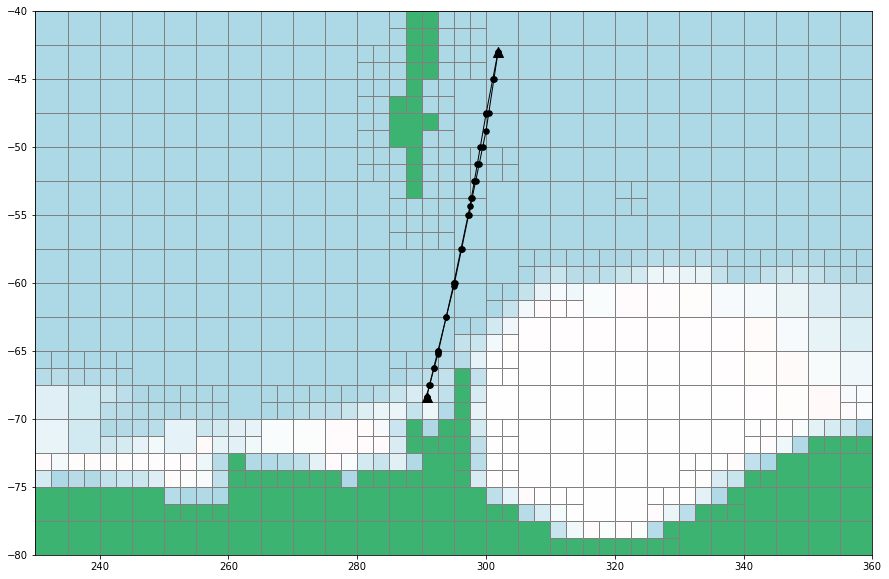

In [9]:
ax = TT.PlotPaths(routepoints=True)

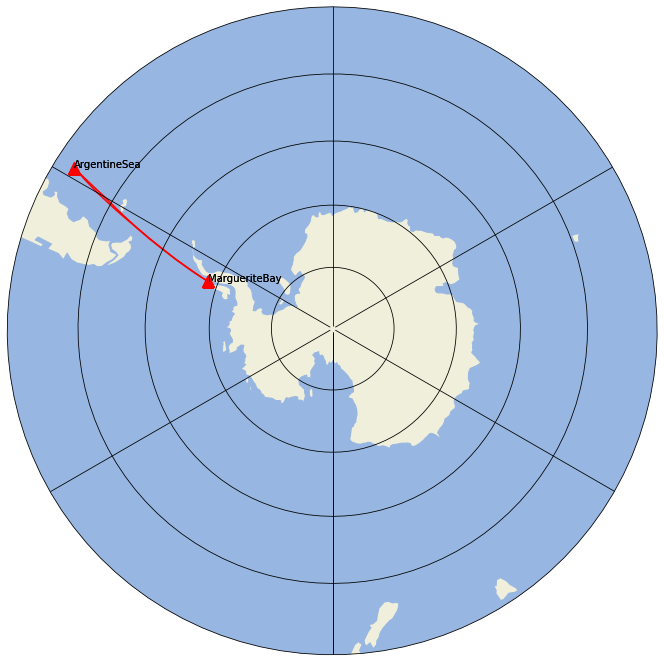

In [8]:
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature

PATH1 =  TT.Paths[0]['Path']['FullPath']

fig = plt.figure(figsize=[10, 10])
ax1 = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)
# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.OCEAN)
ax1.gridlines(color='k')


for ii in range(len(TT.Paths)):
    PATH1 =  TT.Paths[ii]['Path']['FullPath']

    ax1.plot(PATH1[:,0]-360,PATH1[:,1],'r',transform=ccrs.PlateCarree())
    for ii, wpt in OptInfo['WayPoints'].iterrows():
        ax1.scatter(wpt['Long']-360,wpt['Lat'],150,marker='^',color='r',transform=ccrs.PlateCarree())
        ax1.text(wpt['Long']-360,wpt['Lat'],wpt['Name'],transform=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)


In [9]:
import numpy as np
Sp=(294.99994347550927,-65.0);Cp=(295.0,-65.00002225041493)

Cp=(300.0,-52.50230500500922);Np=(299.99948531817694,-52.5)

((np.array(Np)-np.array(Cp))**2).sum()

5.577945471518168e-06